Introduction
------------

We try to solve a 2D knapsack problem using the Google OR-Tools CP-SAT tool. For more information see: 

https://yetanothermathprogrammingconsultant.blogspot.com/2021/10/2d-knapsack-problem.html.


Install/imports
---------------
For colab.google.com, first install or-tools:

In [1]:
! pip install ortools

     |████████████████████████████████| 14.5 MB 81 kB/s 
     |████████████████████████████████| 1.1 MB 53.5 MB/s 
     |████████████████████████████████| 131 kB 46.0 MB/s 
  Attempting uninstall: protobuf
    Found existing installation: protobuf 3.17.3
    Uninstalling protobuf-3.17.3:
      Successfully uninstalled protobuf-3.17.3
  Attempting uninstall: absl-py
    Found existing installation: absl-py 0.12.0
    Uninstalling absl-py-0.12.0:
      Successfully uninstalled absl-py-0.12.0
ERROR: pip's dependency resolver does not currently take into account all the packages that are installed. This behaviour is the source of the following dependency conflicts.
tensorflow-metadata 1.2.0 requires absl-py<0.13,>=0.9, but you have absl-py 0.14.1 which is incompatible.


Import the usual suspects.

In [2]:
from ortools.sat.python import cp_model
from io import StringIO
import pandas as pd
import numpy as np

Data
----

In [3]:
data = '''
item         width    height available    value    color   
k1             20       4       2        338.984   blue
k2             12      17       6        849.246   orange
k3             20      12       2        524.022   green
k4             16       7       9        263.303   red
k5              3       6       3        113.436   purple
k6             13       5       3        551.072   brown
k7              4       7       6         86.166   pink 
k8              6      18       8        755.094   grey
k9             14       2       7        223.516   olive
k10             9      11       5        369.560   cyan
'''

df = pd.read_table(StringIO(data),sep='\s+')

H = 20
W = 30

display(df)
print(f"Container width:{W} height:{H}")

,item,width,height,available,value,color
0,k1,20,4,2,338.984,blue
1,k2,12,17,6,849.246,orange
2,k3,20,12,2,524.022,green
3,k4,16,7,9,263.303,red
4,k5,3,6,3,113.436,purple
5,k6,13,5,3,551.072,brown
6,k7,4,7,6,86.166,pink
7,k8,6,18,8,755.094,grey
8,k9,14,2,7,223.516,olive
9,k10,9,11,5,369.560,cyan


Container width:30 height:20


Derived Data
------------


Here we expand the data to individual items and then introduce rotated items.

In [5]:
# extract columns
w0 = df['width'].to_numpy()
h0 = df['height'].to_numpy()
a0 = df['available'].to_numpy()
v0 = df['value'].to_numpy()
indx0 = np.arange(np.size(w0)) 

# expand to individual items
w = np.repeat(w0,a0)
h = np.repeat(h0,a0)
v = np.repeat(v0,a0)
indx = np.repeat(indx0,a0)

# duplicate to introduce rotated items
wr = np.concatenate((w,h))
hr = np.concatenate((h,w))
vr = np.concatenate((v,v))
vr = (vr*1000.0).astype('int')  # scale values to become integers
indxr = np.concatenate((indx,indx))

n = len(w)
nr = len(wr)
print(f"Number of individual items: {n}")
print(f"Number of individual items (after adding rotations): {nr}")


Number of individual items: 51
Number of individual items (after adding rotations): 102


OR-Tools Model
--------------

Formulate the model. We rely heavily on the **NoOverlap2d** constraint. 

The main idea in this model is to make the width/height of an item zero if it is not selected. 

In [6]:
model = cp_model.CpModel()

#
# variables
#

# u[i] : item i is used
u = [ model.NewBoolVar(f"u{i}") for i in range(nr) ]

# x[i],y[i] : location of item i
x = [ model.NewIntVar(0,W,f"x{i}") for i in range(nr) ]
y = [ model.NewIntVar(0,H,f"y{i}") for i in range(nr) ]

# xw[i],yh[i] : width/height item i
xw = [ model.NewIntVar(0,int(wr[i]),f"xw{i}") for i in range(nr) ]
yh = [ model.NewIntVar(0,int(hr[i]),f"yh{i}") for i in range(nr) ]


# x2[i],y2[i] : upper limit of interval variable
x2 = [ model.NewIntVar(0,W,f"x2{i}") for i in range(nr) ]
y2 = [ model.NewIntVar(0,H,f"y2{i}") for i in range(nr) ]

# interval variables 
xival = [ model.NewIntervalVar(x[i],xw[i],x2[i],f"xival{i}") for i in range(nr) ]
yival = [ model.NewIntervalVar(y[i],yh[i],y2[i],f"yival{i}") for i in range(nr) ]
                               
#
# constraints
#
# The meain idea here is: if an item is not selected, make its
# height and width zero.

# u[i] = 0  ==> xw[i]=yh[i]=0  
# u[i] = 1  ==> xw[i]=hr[i],yh[i]=wr[i]   
for i in range(nr):
  model.Add(xw[i]==wr[i]*u[i])
  model.Add(yh[i]==hr[i]*u[i])

# only one of non-rotated/rotated pair can be used
for i in range(n):
    model.Add(u[i]+u[i+n]<=1)

# no overlap.
model.AddNoOverlap2D(xival,yival)

# extra: this constraint helps performance enormously
model.Add(sum([wr[i]*hr[i]*u[i] for i in range(nr)])<=W*H)

# objective
model.Maximize(sum([u[i]*vr[i] for i in range(nr)]))


Solve model
-----------

This may take a while.

In [8]:
solver = cp_model.CpSolver()
solver.parameters.num_search_workers = 8
rc = solver.Solve(model)
print(f"return code:{rc}")
print(f"status:{solver.StatusName()}")
print()
print(solver.ResponseStats())
print()


return code:4
status:OPTIMAL

CpSolverResponse summary:
status: OPTIMAL
objective: 4617934
best_bound: 4617934
booleans: 494
conflicts: 27206
branches: 45497
propagations: 191823
integer_propagations: 874155
restarts: 331
lp_iterations: 43259
walltime: 54.311
usertime: 54.311
deterministic_time: 14.1113
primal_integral: 69.5022




Solution reporting
------------------

In [12]:
assert(rc==4)

used = {i for i in range(nr) if solver.Value(u[i]) == 1 }
dfout = pd.DataFrame({ 
        'x'   : [solver.Value(x[i]) for i in used],
        'y'   : [solver.Value(y[i]) for i in used],
        'w'   : [wr[i] for i in used],
        'h'   : [hr[i] for i in used],
        'x2'  : [solver.Value(x2[i]) for i in used],
        'y2'  : [solver.Value(y2[i]) for i in used],
        'v'   : [vr[i] for i in used],
        'indx': [indxr[i] for i in used],
        'id'  : [df['item'][indxr[i]] for i in used]
         })
display(dfout)

,x,y,w,h,x2,y2,v,indx,id
0,16,0,14,2,30,2,223516,8,k9
1,16,2,14,2,30,4,223516,8,k9
2,14,18,14,2,28,20,223516,8,k9
3,0,5,5,13,5,18,551072,5,k6
4,16,4,14,2,30,6,223516,8,k9
5,5,5,5,13,10,18,551072,5,k6
6,0,18,14,2,14,20,223516,8,k9
7,10,6,18,6,28,12,755093,7,k8
8,13,0,3,6,16,6,113436,4,k5
9,10,12,18,6,28,18,755093,7,k8


Plotting of solution
--------------------

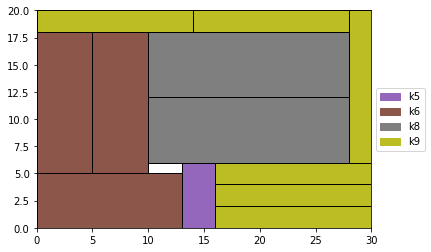

In [15]:
%matplotlib inline
import matplotlib.pyplot as plt
import matplotlib.patches as mpatches

assert(rc==4)

plt.rcParams['figure.figsize'] = [6, 4]

px = dfout['x']
py = dfout['y']
pw = dfout['w']
ph = dfout['h']
pindx = dfout['indx']
colors = [ 'tab:'+df['color'][ind] for ind in pindx ]

fig = plt.figure()
ax = fig.add_subplot(111) 

plt.xlim([0, 30]) 
plt.ylim([0, 20]) 

nn = len(px)
for i in range(nn):
   r = plt.Rectangle((px[i],py[i]),pw[i],ph[i],edgecolor='black',facecolor=colors[i])
   ax.add_patch(r)

used_indx = np.sort(pindx.unique())
ucolors = ['tab:'+ df['color'][i] for i in used_indx]
uname =  [df['item'][i] for i in used_indx]
handle = [ mpatches.Patch(color=ucolors[i],label=uname[i]) for i in range(len(used_indx))  ]
dummy=plt.legend(handles=handle,loc='center left', bbox_to_anchor=(1, 0.5))

